In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import glob
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

import matplotlib.pyplot as plt
import networkx as nx
import pycircos
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

import scanpy as sc

In [2]:
SAVE_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/Module_analysis/'

## Slice SM regions from the pert_cpm_df

In [7]:
GWAS_annot = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB231-dCas9-KRAB+YWsg1P3/enhancer_regions_combined.txt'
SM_annot = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB231-dCas9-KRAB+YWsg2P1/annotation/enhancer_regions_hg38.txt'
GWAS_dict  = {}
SM_dict = {}
with open(GWAS_annot) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split('\t')
        sgrnas = sgrna_string.split(';')
        GWAS_dict.update({region_id : [i.upper() for i in sgrnas]})
        
with open(SM_annot) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split('\t')
        sgrnas = sgrna_string.split(';')
        SM_dict.update({region_id : [i.upper() for i in sgrnas]})      

In [8]:
print(len(GWAS_dict))
print(len(SM_dict))

2038
1475


In [9]:
pert_cpm_df = pd.read_csv('./Pert_cpm_df.csv', index_col=0)

In [10]:
SM_pert_cpm_df = pert_cpm_df[list(SM_dict.keys())]

In [11]:
plot_gene_idx = np.load('/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB361-GWAS+SM/rand_cell/MB361-5perc_expre_gene_idx.npy')

#### Filter with genes expressed in at least 5% of cells

In [12]:
SM_pert_cpm_df.iloc[plot_gene_idx, :]

,chr10:100433357-100434204,chr10:104121485-104122192,chr10:109650151-109650750,chr10:110081941-110082441,chr10:110567456-110568156,chr10:113087196-113087696,chr10:113750454-113751454,chr10:118754500-118755000,chr10:118912961-118913570,chr10:119006751-119007354,...,chrX:5236020-5236520,chrX:54999894-55000394,chrX:64205836-64206336,chrX:6660814-6661368,chrX:70089837-70090337,chrX:7083969-7084471,chrX:84187105-84187611,chrX:87409426-87409968,chrX:9153198-9153747,chrX:96685614-96686288
RP5-857K21.9,9.138736,10.974234,9.683195,10.045726,9.732325,11.676450,10.181455,10.659318,10.500627,10.048417,...,11.771735,8.292195,9.961404,10.730592,10.495239,8.730332,10.889627,9.663379,10.817571,8.843071
RP5-857K21.6,18.827123,18.173648,18.155427,20.050973,19.510521,19.643147,19.482916,23.027209,19.348608,21.041070,...,20.365586,22.309970,21.885221,22.050650,19.270492,19.529350,19.460801,18.319867,21.619053,21.474558
RP5-857K21.10,315.635671,327.182728,330.892890,313.258093,326.352386,312.947367,316.941537,320.047179,314.702810,315.514842,...,330.220135,319.124195,304.720788,329.685047,315.745928,317.969179,302.132961,322.726723,317.869659,329.948793
RP11-206L10.11,9.374438,7.401299,8.291598,9.145902,8.469757,8.438587,8.561046,7.959789,10.114713,8.705385,...,11.127585,9.916184,9.368960,8.215090,8.238373,8.796087,6.053685,9.245026,9.300423,8.235298
SAMD11,8.154599,10.734162,6.916649,7.234862,7.929779,8.350752,9.776810,7.883087,7.935635,9.055988,...,8.505617,10.422469,9.609679,8.202051,9.416282,8.931500,8.233401,8.372462,10.270524,8.386996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT-ND5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT-ND6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT-CYB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
adata = sc.AnnData(SM_pert_cpm_df.iloc[plot_gene_idx, :].T, 
    SM_pert_cpm_df.iloc[plot_gene_idx, :].T.index.to_frame(), 
    SM_pert_cpm_df.iloc[plot_gene_idx, :].T.columns.to_frame())

In [14]:
adata

AnnData object with n_obs × n_vars = 1475 × 9656
    obs: 0
    var: 0

In [15]:
#use recipe from Zheng et al
sc.pp.recipe_zheng17(adata, n_top_genes = 1000)

# Transpose: gene based clustering

In [16]:
transpose_singlet_mtx = adata.transpose()

## PCA

In [17]:
sc.tl.pca(transpose_singlet_mtx,
          n_comps=50,
          random_state=0)

In [18]:
transpose_singlet_mtx

AnnData object with n_obs × n_vars = 999 × 1475
    obs: 0, 'n_counts', 'mean', 'std'
    var: 0, 'n_counts_all'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute a neighborhood graph of observations

In [19]:
sc.pp.neighbors(
    transpose_singlet_mtx,
    n_neighbors=15,
    use_rep='X_pca'
)

### UMAP visualization

In [20]:
sc.tl.umap(transpose_singlet_mtx, 
          random_state=0)

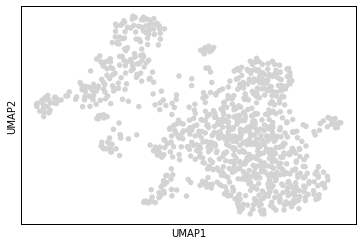

In [21]:
sc.pl.umap(transpose_singlet_mtx)

### Louvain clustering

In [22]:
sc.tl.louvain(
    transpose_singlet_mtx,
    resolution=0.4) #higher resolution, more clusters

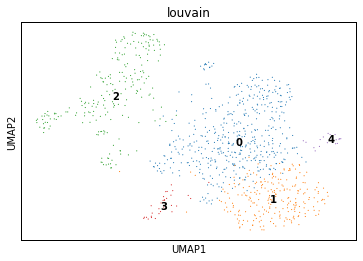

In [23]:
sc.pl.umap(
        transpose_singlet_mtx, 
        color=['louvain'],
        size=5, 
        legend_loc='on data')

### PAGA

In [24]:
sc.tl.paga(
    transpose_singlet_mtx,
    groups='louvain',  
)

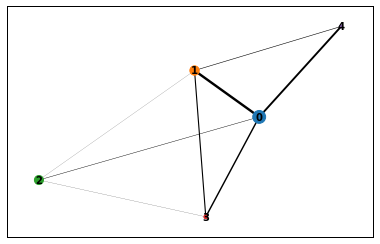

In [25]:
sc.pl.paga(
    transpose_singlet_mtx, 
    color=['louvain'], 
    use_raw=True,
#    use_raw=False,
#    layout='fa', 
    layout='fr', 
    threshold=0.01, 
    node_size_scale=0.5,
    node_size_power=0.9, 
#    random_state=random_seed, 
)

In [26]:
sc.tl.umap(
    transpose_singlet_mtx,
    init_pos='paga', 
#    random_state=random_seed,
)

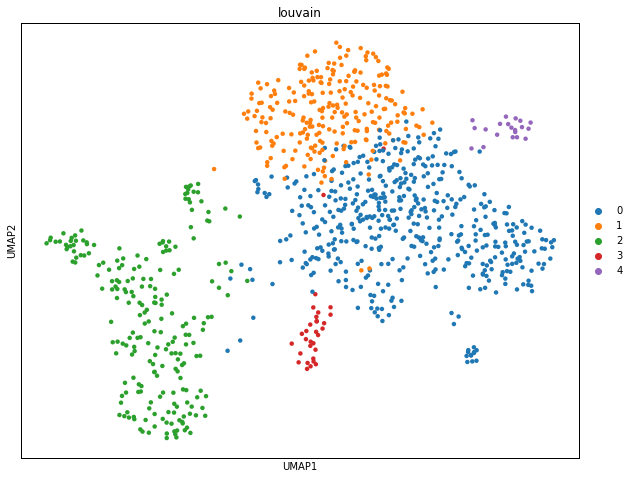

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(transpose_singlet_mtx, 
          color=['louvain'],
          size=80, 
          ax=ax,
          save='MB361_SM_gene_program_UMAP.png'
          )

In [62]:
adata.var['program_louvain'] = transpose_singlet_mtx.obs['louvain']

# Perturbation based clustering

In [69]:
adata

AnnData object with n_obs × n_vars = 1475 × 999
    obs: 'n_counts_all', 'louvain'
    var: 'n_counts', 'mean', 'std', 'program_louvain'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'paga', 'louvain_sizes'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## PCA

In [70]:
sc.tl.pca(adata,
          n_comps=50,
          random_state=0)

In [71]:
adata

AnnData object with n_obs × n_vars = 1475 × 999
    obs: 'n_counts_all', 'louvain'
    var: 'n_counts', 'mean', 'std', 'program_louvain'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'paga', 'louvain_sizes'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Compute a neighborhood graph of observations

In [72]:
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    use_rep='X_pca'
)

### UMAP visualization

In [73]:
sc.tl.umap(adata, 
          random_state=0)

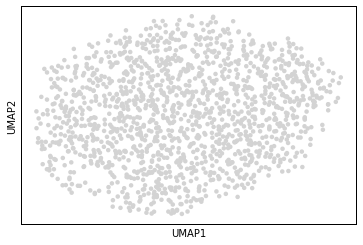

In [74]:
sc.pl.umap(adata)

### Try tsne

In [75]:
sc.tl.tsne(adata, 
          random_state=0)

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


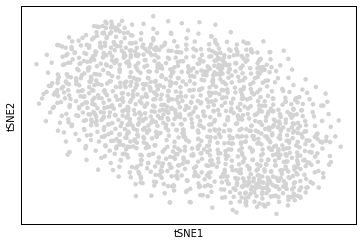

In [76]:
sc.pl.tsne(adata)

### Louvain clustering

In [77]:
sc.tl.louvain(
    adata,
    resolution=0.6) #higher resolution, more clusters

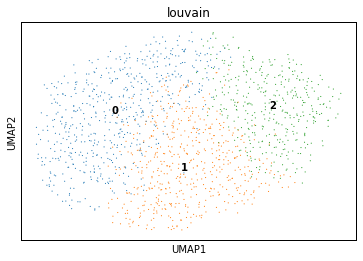

In [78]:
sc.pl.umap(
        adata, 
        color=['louvain'],
        size=5, 
        legend_loc='on data')

### PAGA

In [79]:
sc.tl.paga(
    adata,
    groups='louvain',  
)

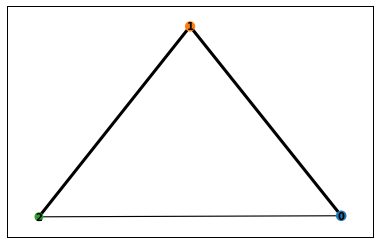

In [80]:
sc.pl.paga(
    adata, 
    color=['louvain'], 
    use_raw=True,
#    use_raw=False,
#    layout='fa', 
    layout='fr', 
    threshold=0.01, 
    node_size_scale=0.5,
    node_size_power=0.9, 
#    random_state=random_seed, 
)

In [81]:
sc.tl.umap(
    adata,
    init_pos='paga', 
#    random_state=random_seed,
)

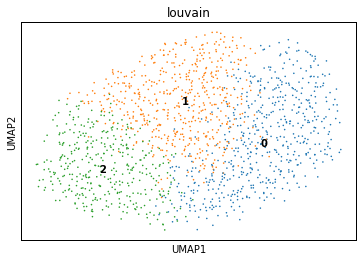

In [82]:
sc.pl.umap(
        adata, 
        color=['louvain'],
        size=10, 
        legend_loc='on data')

In [83]:
adata

AnnData object with n_obs × n_vars = 1475 × 999
    obs: 'n_counts_all', 'louvain'
    var: 'n_counts', 'mean', 'std', 'program_louvain'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'paga', 'louvain_sizes'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## combine gene based clustering and perturbation based clustering to plot heatmap

In [3]:
adata = sc.read_h5ad('./12SMmodule_adata.h5ad')

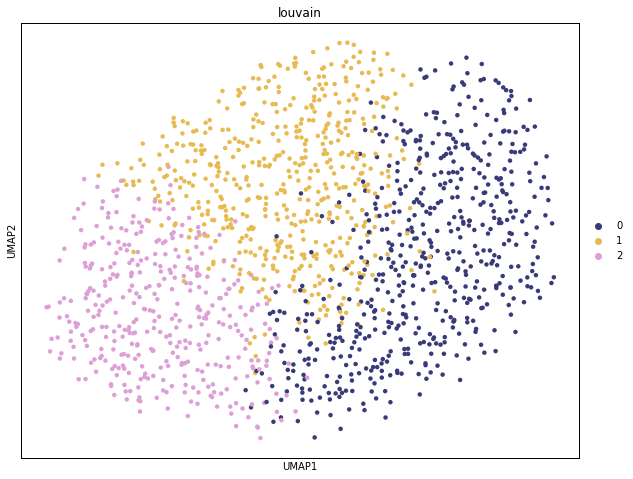

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(adata, 
           color=['louvain'],
           palette='tab20b',
           size=80, 
           ax=ax,
           save='MB361_SM_perturbation_module_UMAP_v2.png'
           )

In [4]:
obs_df = pd.DataFrame(index=adata.var_names, data={'program_louvain': adata.var['program_louvain'].values})
var_df = pd.DataFrame(index=adata.obs_names, data={'louvain': adata.obs['louvain'].values})
sorted_obs = obs_df.sort_values(by=['program_louvain'])
sorted_var = var_df.sort_values(by=['louvain'])

In [5]:
# create the sorted AnnData object
step1_df = adata.transpose()[:, sorted_var.index]
sorted_adata = step1_df[sorted_obs.index, :]

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


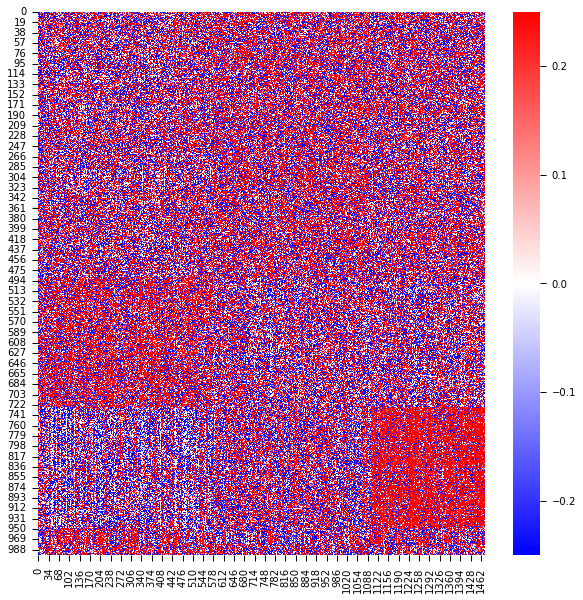

In [20]:
# plot the heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.log1p(sorted_adata.X), cmap='bwr', ax=ax, vmax=0.25, vmin=-0.25, rasterized=True)
#plt.show()
plt.savefig(SAVE_DIR + 'SM_module_program_heatmap_v2.pdf')

In [88]:
adata.write('./12SMmodule_adata.h5ad')

In [34]:
for i in adata.var[adata.var['program_louvain'] == '4'].index:
    print(i)

ISG15
IFI6
IFIH1
STAT1
PARP14
PLSCR1
TNFSF10
PPM1K
HERC6
SAMD9
DDX58
MSMB
IFIT1
IFITM3
OAS1
OAS3
ISG20
SLFN5
IFI35
APOL1


## Correlation

In [27]:
perturbation_covariance_df = pd.read_csv('./SM_Perturb_covariance_df.csv', index_col=0)

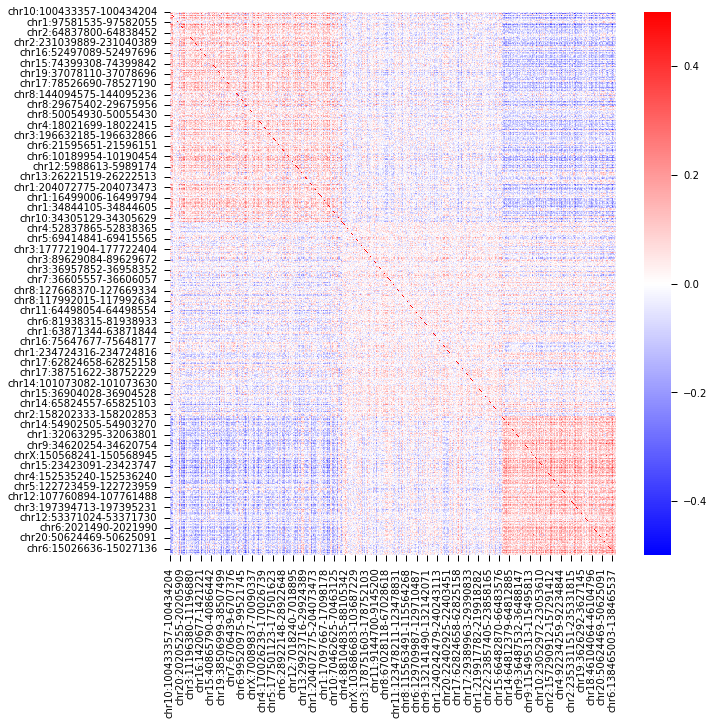

In [32]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(perturbation_covariance_df.astype(float), cmap='bwr', ax=ax, vmax=0.5, vmin=-0.5, rasterized=True)
plt.savefig(SAVE_DIR + 'SM_perturbation_correlation.pdf')

In [33]:
gene_covariance_df = pd.read_csv('./SM_Gene_covariance_df.csv', index_col=0)

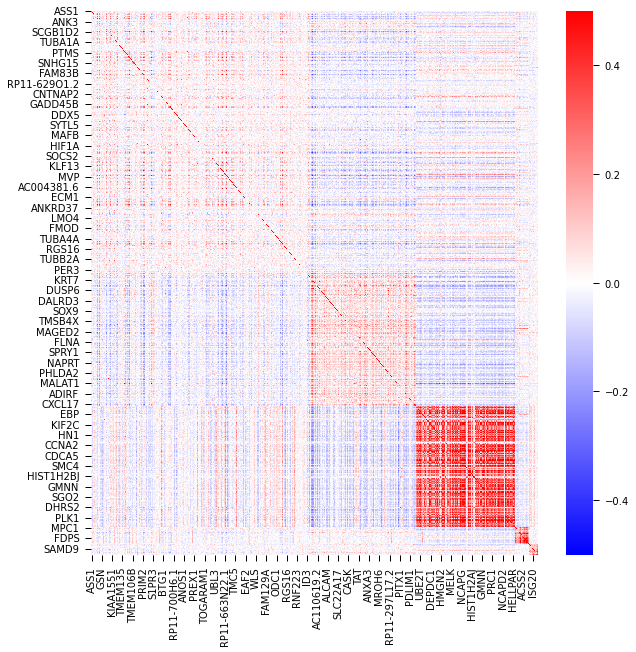

In [36]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(gene_covariance_df.astype(float), cmap='bwr', ax=ax, vmax=0.5, vmin=-0.5, rasterized=True)
plt.savefig(SAVE_DIR + 'SM_gene_correlation.pdf')

## Plot similarity of each gene program

In [ ]:
GWAS_adata = sc.read('./11GWASmodule_adata.h5ad')

In [ ]:
len(set(GWAS_adata.var.index).intersection(set(adata.var.index)))

838

In [ ]:
similarity_table = pd.DataFrame(data=None, columns=['0', '1', '2', '3', '4'], index=['0', '1', '2', '3', '4'] )
for i in similarity_table.index:
    for j in similarity_table.columns:
        similarity = len(set(GWAS_adata.var[GWAS_adata.var['program_louvain'] == i].index).intersection(set(adata.var[adata.var['program_louvain'] == j].index))) / \
                     len(set(GWAS_adata.var[GWAS_adata.var['program_louvain'] == i].index).union(set(adata.var[adata.var['program_louvain'] == j].index))) 
        similarity_table.loc[i, j] = similarity

In [ ]:
similarity_table

,0,1,2,3,4
0,0.232727,0.383094,0.0,0.001786,0.029963
1,0.00289,0.0,0.758197,0.0,0.0
2,0.284884,0.0,0.0,0.0,0.0
3,0.059387,0.003289,0.0,0.426471,0.011765
4,0.001972,0.0,0.084821,0.0,0.0


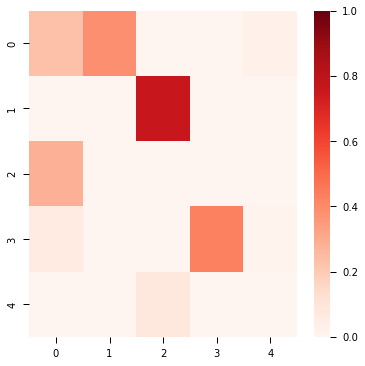

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(similarity_table.astype(float), cmap='Reds', ax=ax, vmax=1, vmin=0)
plt.show()

In [ ]:
All_adata = sc.read('./8module_adata.h5ad')

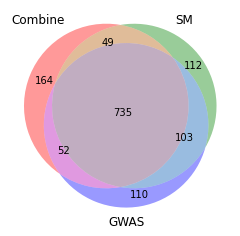

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set1 = set(All_adata.var.index)
set2 = set(adata.var.index)
set3 = set(GWAS_adata.var.index)

venn3([set1, set2, set3], ('Combine', 'SM', 'GWAS'))

plt.show()

#most of the highly variable genes are the same between Combine, SM and GWAS

### Similarity of combine gene program to split screen

In [ ]:
GWAS_similarity_table = pd.DataFrame(data=None, columns=['0', '1', '2', '3', '4'], index=['0', '1', '2', '3', '4'] )
for i in GWAS_similarity_table.index:
    for j in GWAS_similarity_table.columns:
        similarity = len(set(GWAS_adata.var[GWAS_adata.var['program_louvain'] == i].index).intersection(set(All_adata.var[All_adata.var['program_louvain'] == j].index))) / \
                     len(set(GWAS_adata.var[GWAS_adata.var['program_louvain'] == i].index).union(set(All_adata.var[All_adata.var['program_louvain'] == j].index))) 
        GWAS_similarity_table.loc[i, j] = similarity

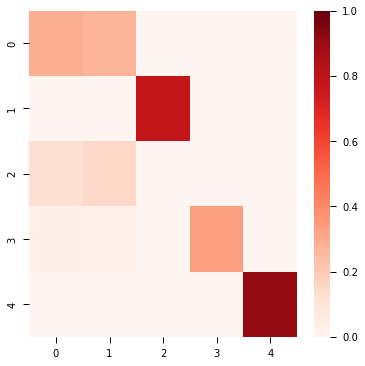

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(GWAS_similarity_table.astype(float), cmap='Reds', ax=ax, vmax=1, vmin=0)
plt.show()

In [ ]:
SM_similarity_table = pd.DataFrame(data=None, columns=['0', '1', '2', '3', '4'], index=['0', '1', '2', '3', '4'] )
for i in SM_similarity_table.index:
    for j in SM_similarity_table.columns:
        similarity = len(set(adata.var[adata.var['program_louvain'] == i].index).intersection(set(All_adata.var[All_adata.var['program_louvain'] == j].index))) / \
                     len(set(adata.var[adata.var['program_louvain'] == i].index).union(set(All_adata.var[All_adata.var['program_louvain'] == j].index))) 
        SM_similarity_table.loc[i, j] = similarity

## GSEA of perturbation module 

In [ ]:
adata = sc.read_h5ad('./12SMmodule_adata.h5ad')

In [ ]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 
                    'color_idx', 'chr_idx', 'region', 'distance', 'num_cell', 'bin', 
                    'pval', 'fc', 'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [ ]:
local_df = pd.read_csv('../MB361-filter_local_df.csv')[local_df_columns]

In [ ]:
local_df

,idx,gene_names,chromosome,pos,strand,color_idx,chr_idx,region,distance,num_cell,bin,pval,fc,padj-Gaussian,fc_by_rand_dist_cpm
0,1287,CITED4,chr1,40862366,-,0,0,chr1:40862276-40862776,90,1476,1500,-2.509728,0.874915,-6.845482e+06,0.732475
1,1287,CITED4,chr1,40862366,-,0,0,chr1:40919322-40919917,56956,1374,1400,-2.417686,0.790645,-4.287301e+05,0.662337
2,30306,IFITM3,chr11,1809008588,-,0,10,chr11:320278-320778,7259,1764,1800,-130.374236,0.409566,-3.484352e+05,0.416381
3,3281,PMVK,chr1,154936991,-,0,0,chr1:154936783-154937283,208,1362,1400,-25.152860,0.657398,-3.223401e+05,0.616871
4,42259,HAGHL,chr16,2401169153,+,1,15,chr16:726229-726752,707,1087,1100,-6.733912,0.783189,-6.180115e+04,0.694453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,48940,KISS1R,chr19,2655328575,+,0,18,chr19:459516-460120,457771,1115,1100,-3.840005,0.590640,-1.510897e+01,0.548770
362,18123,BTN2A1,chr6,1087656228,+,1,5,chr6:26457686-26458186,218,1406,1400,-2.695434,0.729192,-1.504333e+01,0.727862
363,51657,ZSCAN5A,chr19,2710779671,-,0,18,chr19:57803578-57804141,1435195,1157,1200,-4.789457,0.525544,-1.504106e+01,0.557160
364,3240,RP11-422P24.12,chr1,153964361,+,0,0,chr1:153633698-153634232,330663,992,1000,-3.682290,0.519316,-1.502324e+01,0.498757


In [ ]:
for i in adata.obs[adata.obs['louvain'] == '0'].index:
    if len(local_df[local_df['region'] == i]['gene_names']) > 0:
        print(local_df[local_df['region'] == i]['gene_names'].values[0])

PLEKHS1
RP11-506B4.3
RP11-126H7.3
TRIM45
HIST2H4B
RP11-422P24.12
RP11-307C12.12
RP11-307C12.12
IQGAP3
TPCN2
PIGC
RSG1
STX2
RP11-378J18.3
ADCK3
IFNLR1
PHLDA1
FLT3
TGDS
RRAGC
CITED4
MDGA2
RPS6KL1
PLA2G4F
MESP1
LA16c-431H6.7
NPIPA1
NAGPA
CTB-58E17.3
ACSF2
TMEM102
BZRAP1
TEX14
RHBDF2
RBP7
MIER2
PLEKHF1
CTD-3064H18.1
ZNF567
RP11-488P3.1
CLASRP
AMH
ZNF468
AC005037.3
CECR5
FN1
AC104667.3
FNDC4
TXNRD3
LIMD1-AS1
CDKL3
ZNF354A
HIST1H2AM
XXbac-BPG170G13.33
RP3-468B3.3
PBX2
RP11-7K24.3
RP11-98I9.4
AC096582.7
AC007009.1
LRRC6
OPLAH
NUDT18
KIF24
KLHL15
PRRG1


In [ ]:
for i in adata.obs[adata.obs['louvain'] == '1'].index:
    if len(local_df[local_df['region'] == i]['gene_names']) > 0:
        print(local_df[local_df['region'] == i]['gene_names'].values[0])

AKR1C3
SCGB2A1
GAL
ARRB1
RP11-465N4.4
PIK3C2B
ITPKB
ZNF692
TNS2
HOXC13
ATP23
SCEL
RN7SL1
TMEM53
GALC
PRR14
ZNF668
C16orf89
SLC38A7
CLEC3A
KAT2A
ALOX12P2
YBX2
BAIAP2-AS1
RAVER1
KISS1R
ZNF333
ZNF14
POU2F2
RP11-15A1.3
AC007191.4
PPP6R1
ZNF582
ZSCAN5A
SNX7
SLC9A8
PHACTR3
SGSM1
EXOC6B
ALG1L
ARHGAP18
HIST1H4H
BTN3A1
PRSS16
DUSP22
RAPGEF5
RP11-44N11.3
GPRASP2


In [ ]:
for i in adata.obs[adata.obs['louvain'] == '2'].index:
    if len(local_df[local_df['region'] == i]['gene_names']) > 0:
        print(local_df[local_df['region'] == i]['gene_names'].values[0])

ZNF37A
ZNF487
PLEKHA7
S100A13
ROM1
B4GAT1
RHOU
RP11-793H13.11
DNAJC14
AGAP2
TMEM39B
CFL2
KIF7
CORO1A
ZDHHC1
HAGHL
DHRS11
CD22
KCNJ14
ZNF324
JAG1
VSTM2L
SALL4
AC092667.2
AF042090.2
CARF
RP11-271C24.3
CTSO
FAM53C
CAPSL
ULBP2
SYTL3
RP1-86C11.7
ZBTB22
AC002467.7
TRIB1
PDLIM2
TNFSF15
